# 1. Brief description of the problem and data

The rapid advancements in artificial intelligence and machine learning have led to significant progress in various domains. Now, we have a chance to utilize AI to tackle the problem of identifying metastatic cancer in small image patches taken from larger digital pathology scans. A Convolutional Neural Network (CNN) is better to solve this kind of a binary image classification problem, where the goal is to determine whether a given image patch contains metastatic cancer or not. 

The data for this challenge is based on the PatchCamelyon (PCam) benchmark dataset, which has been modified to remove duplicate images. PCam dataset is interesting due to its size, simplicity, and approachability. It allows for models to be trained on a single GPU within a few hours and achieve competitive scores. As for the Natural Language Processing (NLP) task, it involves the processing, understanding, and generation of human language by computer algorithms. NLP techniques are widely used for tasks such as sentiment analysis, machine translation, and chatbot development.

# 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

**2.1 Load data and list the images**

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#import seaborn as sns
from PIL import Image
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift + Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**2.2 Label files Exploration**

In [3]:
import pandas as pd
import os

# Set the paths to the CSV files
sample_submission_path = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'
train_labels_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

# Read the CSV files
sample_submission_df = pd.read_csv(sample_submission_path)
train_labels_df = pd.read_csv(train_labels_path)

# Display the first few rows of each DataFrame
print("Sample Submission DataFrame:")
print(sample_submission_df.head())

print("\nTrain Labels DataFrame:")
print(train_labels_df.head())

# Data cleaning: Check for missing values
missing_values = train_labels_df.isnull().sum()
print("Missing values:\n", missing_values)

# Visualize the distribution of the target variable (label)
#plt.figure(figsize=(3, 3))
#sns.countplot(x='label', data=train_labels_df)
#plt.title('Histogram of Target Variable (Label)')
#plt.xlabel('Label')
#plt.ylabel('Count')
#plt.show()

Sample Submission DataFrame:
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

Train Labels DataFrame:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Missing values:
 id       0
label    0
dtype: int64


**2.3 Visualize the pictures**

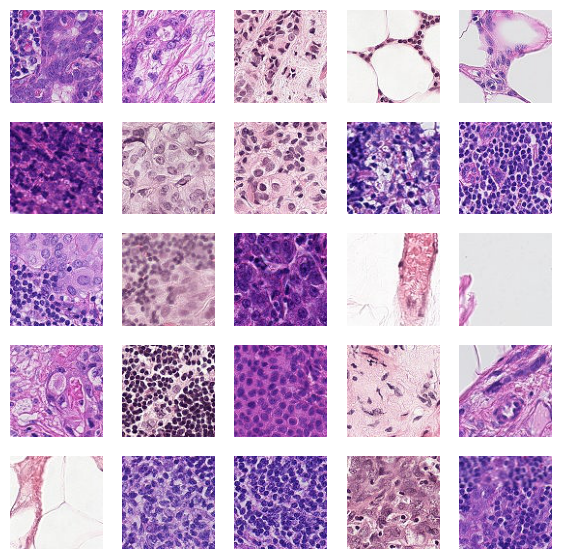

In [4]:
# Set the path to the images
train_images_path = '/kaggle/input/histopathologic-cancer-detection/train/'

# Get a list of image file names
image_files = os.listdir(train_images_path)

# Randomly select a few images
num_images_to_show = 25
selected_images = random.sample(image_files, num_images_to_show)

# Plot the selected images in a grid
fig, axes = plt.subplots(5, 5, figsize=(7, 7))
axes = axes.ravel()

for i, img_name in enumerate(selected_images):
    img_path = os.path.join(train_images_path, img_name)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

# 3.Model to choose

For the problem of histopathologic cancer detection, we can start with a Convolutional Neural Network (CNN) as it is well-suited for image classification tasks. Below, I will describe a possible model architecture and the reasoning behind the choices made.

** Input Layer: The model accepts RGB images of size (96, 96) pixels.

** Convolutional Layers: The model consists of 5 convolutional layers, each followed by batch normalization, ReLU activation function, and max-pooling layer. The first layer applies 32 filters of size (3, 3) to capture basic features such as edges and textures, and the number of filters increases up to 512 in the last layer to learn more complex features. The padding is set to 1 to preserve the spatial dimensions of the input.

** Flatten Layer: The output from the last convolutional layer is flattened into a 1D array of size 4608 before being passed to the fully connected layers.

** Fully Connected Layers: The model has 2 fully connected layers, with 256 and 2 neurons respectively. The first layer has a ReLU activation function and batch normalization, while the second layer has no activation function. Dropout with a rate of 0.4 is applied after the first fully connected layer to reduce overfitting.

** Output Layer: The final layer is a dense layer with 2 neurons and no activation function, which produces the logits for each class.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        num_classes = 2
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 32, 3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, 3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv3 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv4 = nn.Sequential(
                        nn.Conv2d(128, 256, 3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv5 = nn.Sequential(
                        nn.Conv2d(256, 512, 3, stride=1, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.fc = nn.Sequential(
                  nn.Linear(512 * 3 * 3, 256),
                  nn.ReLU(inplace=True),
                  nn.BatchNorm1d(256),
                  nn.Dropout(0.4),
                  nn.Linear(256, num_classes))  

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.reshape(x.shape[0], -1) 
        x = self.fc(x)
        return x


#summary(cnn_model, input_size=(3, 46, 46), device=device.type)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = CancerNet().to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), p

# 4. Results and Analysis

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.
Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

**4.1 Split the datasets**

In [14]:
import os
import pandas as pd
import numpy as np

!pip install scikit-learn
#!conda install scikit-learn -y

!pip install scikit-image
#!conda install scikit-image -y

from skimage.io import imread
from skimage.transform import resize

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the first image using the file name and path
first_image = imread(os.path.join(train_images_path, image_files[0]))

# Get the dimensions of the image
height, width, channels = first_image.shape

print(f"Image width: {width}")
print(f"Image height: {height}")
print(f"Image dimensions: {width} x {height} x {channels}")

# Load train labels
train_labels_df = pd.read_csv(train_labels_path)

# Select 0.01% of the data
selected_data = train_labels_df.sample(frac = 0.1, random_state=42)

# Split the selected dataset into training and validation sets (1/10 for training)
train_df, val_df = train_test_split(selected_data, train_size=0.7, random_state=42)

print(f"Number of images in train_labels_df: {train_labels_df.shape[0]}")
print(f"Number of images in selected_data: {selected_data.shape[0]}")
print(f"Number of images in train_df: {train_df.shape[0]}")
print(f"Number of images in val_df: {val_df.shape[0]}")

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Image width: 96
Image height: 96
Image dimensions: 96 x 96 x 3
Number of images in train_labels_df: 220025
Number of images in selected_data: 22002
Number of images in train_df: 15401
Number of images in val_df: 6601


**4.2 Preprocess the image data (resize, normalize, etc.)**

In [16]:
# Create a custom dataset class
class CancerDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0]) + '.tif'
        image = imread(img_name)
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

transform_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_val = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_test = transforms.Compose([transforms.ToPILImage(), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])


# Create datasets and data loaders
train_dataset = CancerDataset(train_df, train_images_path, transform=transform_train)
val_dataset = CancerDataset(val_df, train_images_path, transform=transform_val)
#test_dataset = CancerDataset(val_df, train_images_path, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

**4.3 Build and evaluate our model**

In [18]:
import tqdm

learning_rate = 0.001  # Define the learning rate for the optimizer

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

# Compile the model
#optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
#criterion = torch.nn.BCEWithLogitsLoss()


# Train the model
num_epochs = 5
train_loss_history = []
val_loss_history = []

# Initialize variables for checkpointing
checkpoint_path = "/kaggle/working/checkpoint.pth"
best_val_loss = float("inf")

# Reload the checkpoint
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Model successfully reloaded from checkpoint at epoch {epoch}")


for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    model.train()
       
    for images, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1} (Training)"):
        images, labels = images.to(device), labels.to(device)

        # Rest of the code inside the loop
        optimizer.zero_grad()
        outputs = model(images)
        #loss = criterion(outputs.squeeze(), labels.float())
        #loss = criterion(outputs.squeeze(), labels.unsqueeze(1))
        loss = criterion(outputs, labels.long())
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1} (Validation)"):
            images, labels = images.to(device), labels.to(device)
                
            outputs = model(images)
            #loss = criterion(outputs.squeeze(), labels.float())
            #loss = criterion(outputs.squeeze(), labels.unsqueeze(1))
            loss = criterion(outputs, labels.long())

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    # Checkpoint the model if the validation loss improves
    if val_loss < best_val_loss:
        print("Saving checkpoint...")
        best_val_loss = val_loss
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_loss_history": train_loss_history,
            "val_loss_history": val_loss_history,
        }
        torch.save(checkpoint, checkpoint_path)


Epoch 1 (Validation): 100%|██████████| 207/207 [00:20<00:00, 10.28it/s]


Epoch 1, Train Loss: 0.4086261559200485, Val Loss: 0.34998944005816457
Saving checkpoint...


Epoch 2 (Validation): 100%|██████████| 207/207 [00:19<00:00, 10.40it/s]


Epoch 2, Train Loss: 0.3665217049883609, Val Loss: 0.3425923267352408
Saving checkpoint...


Epoch 3 (Validation): 100%|██████████| 207/207 [00:19<00:00, 10.51it/s]


Epoch 3, Train Loss: 0.34302844063869653, Val Loss: 0.31157815611160894
Saving checkpoint...


Epoch 4 (Validation): 100%|██████████| 207/207 [00:20<00:00, 10.01it/s]


Epoch 4, Train Loss: 0.3314862850728866, Val Loss: 0.3025289744426663
Saving checkpoint...


Epoch 5 (Validation): 100%|██████████| 207/207 [00:19<00:00, 10.36it/s]

Epoch 5, Train Loss: 0.32018460725971276, Val Loss: 0.30353992191201823


**4.4 Fine-tune the model**

(if necessary) and make predictions on the test data

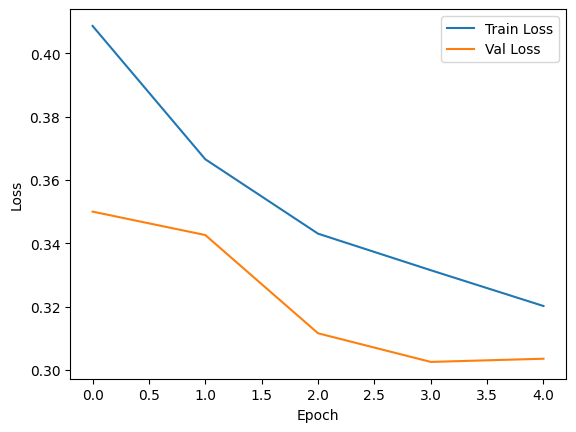

In [19]:
# Plot the loss history
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**4.5 Make predictions and save the result**

In [20]:
import numpy as np
import os
import torch
import pandas as pd
from skimage.io import imread

model.eval()

test_images_path = '/kaggle/input/histopathologic-cancer-detection/test/'
test_image_files = os.listdir(test_images_path)
#test_image_files = test_image_files[:10]

batch_size = 128
num_images = len(test_image_files)
predictions = []

for i in range(0, num_images, batch_size):
    batch_files = test_image_files[i:i + batch_size]
    batch_images = [imread(os.path.join(test_images_path, img_file)) for img_file in batch_files]
    batch_images_normalized = np.array(batch_images) / 255.0
    #batch_images_tensor = torch.tensor(batch_images_normalized, dtype=torch.float32).permute(0, 3, 1, 2)
    batch_images_tensor = torch.tensor(batch_images_normalized, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

    
    with torch.no_grad():
        model.eval()
#       batch_predictions = model(batch_images_tensor).numpy()
        batch_predictions = model(batch_images_tensor).cpu().numpy()

        predictions.extend(batch_predictions)

predictions = np.array(predictions)
#binary_predictions = (predictions > 0.5).astype(int).flatten()
binary_predictions = [(p[0] > 0.5) for p in predictions]
binary_predictions = [1 if p else 0 for p in binary_predictions]

for i in range(10):
    print(f"Image {i + 1}: {test_image_files[i]}")
    print(f"Probability: {predictions[i][0]:.4f}")
    print(f"Predicted Label: {binary_predictions[i]}\n")

submission_df = pd.DataFrame({'id': [img_file[:-4] for img_file in test_image_files], 'label': binary_predictions})
submission_df = submission_df.replace({'label': {'FALSE': 0, 'TRUE': 1}})

print(f"Total number of predictions: {len(submission_df)}")

Image 1: a7ea26360815d8492433b14cd8318607bcf99d9e.tif
Probability: 1.1920
Predicted Label: 1

Image 2: 59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
Probability: 1.6176
Predicted Label: 1

Image 3: 5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
Probability: 0.6227
Predicted Label: 1

Image 4: bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
Probability: 1.0073
Predicted Label: 1

Image 5: 523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif
Probability: -0.0003
Predicted Label: 0

Image 6: d23c66547f4a00555a174d2fcb860ae399b66edc.tif
Probability: 0.8580
Predicted Label: 1

Image 7: fabf2fca23f71655974767e29eda86a9b2c97a72.tif
Probability: 1.8662
Predicted Label: 1

Image 8: 9730b15862516b8641b9f0ff48db660d95031c32.tif
Probability: 2.0484
Predicted Label: 1

Image 9: ee85348c0950c2e639776fb555e3452c1f8437c0.tif
Probability: 2.2462
Predicted Label: 1

Image 10: ef12a0813c504d2d1b2ba485e78d380ad64a0622.tif
Probability: 1.9969
Predicted Label: 1

Total number of predictions: 57458


In [21]:
# Remove the old submission.csv file if it exists
submission_csv_path = '/kaggle/working/submission.csv'
if os.path.exists(submission_csv_path):
    os.remove(submission_csv_path)

submission_df.to_csv(submission_csv_path, index=False)

#shutil.make_archive('/kaggle/working/working_directory', 'zip', '/kaggle/working/')

# 5. Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

# 6. Produce Deliverables

High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard 
These deliverables serve two purposes- grade for this course and your project portfolio that you can show when you apply for jobs.
